In [18]:
# Importing necessary modules
import gc
import copy
import os
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from model_data_definitions import *
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import os
import numpy as np

In [20]:
def modelNames():

    models = ["Linear Model",
              "Wide ReLU ANN",
              "Deep ReLU ANN", 
              "One Parameter"
    ]

    for partition_num in [1,2,4,8,10]:
        models.append(f"Spline ANN (z={partition_num})")
        models.append(f"Lookup Table (z={partition_num})")
        models.append(f"ABEL-Spline (z={partition_num})")

    return models

model_names = modelNames()

# Function to train and evaluate model

def train_evaluate_model(model_tuple, fold_data, epoch_number, dataset_name,num_folds):
    
    
    model, name = model_tuple
    X_train, y_train, X_test, y_test , fold = fold_data
    
    print(f"Evaluating{name} for {fold}")
    
    # Training the model 
    history = model.fit(X_train,
                        y_train,
                        epochs=epoch_number,
                        verbose=1,
                        validation_data=(X_test,y_test))

     # Evaluating the trained model on test data 
    loss = model.evaluate(X_test,y_test)

     # Making predictions on the test data 
    predictions = model.predict(X_test)
    
     # Calculate metrics 
    r_squared_value=r2_score(y_true=y_test,y_pred=predictions)
    test_error=mean_squared_error(y_true=y_test,y_pred=predictions)

    results = {
        'model': name,
        'fold': fold,
        'train_history': history.history['loss'],
        'val_history': history.history['val_loss'],
        'loss': loss,
        'r_squared_value': r_squared_value,
        'test_error': test_error}

    # Save results to numpy file
    if not os.path.exists('aggregate_results'):
        os.makedirs('aggregate_results')

    np.save(f'aggregate_results/{dataset_name}-{name}-epochs-{epoch_number}-fold-{fold}-of-{num_folds}.npy', results)

# Directory where your npy files are stored
directory = 'aggregate_results'

# Initialize dictionary to hold data
data = {}

# Get list of all model names
models = initialize_all_models(1, 1)  # Arguments don't matter here.
model_names = [name for _, name in models]

# Iterate over files in directory
for filename in os.listdir(directory):
    if "-epochs-100-fold-" in filename and "-of-10.npy" in filename:
        #print(filename)
        
        # Split filename into parts
        parts = filename.split('-')
        print(parts)
        #print(parts[-3])

        # Extract dataset name (up to first hyphen)
        dataset_name = parts[0]
        #print(dataset_name)
        
        # Extract model name (from first hyphen to "epochs")
        model_name_parts = parts[1:-6].copy()
        model_name = '-'.join(model_name_parts)
        #print(model_name)

        # Skip file if not one of the expected models
        #if model_name not in model_names:
        #    continue

        # Extract fold number (from "fold" to "of")
        fold_number = parts[-3]
        
        # Load file 
        file_data = np.load(os.path.join(directory, filename), allow_pickle=True).item()

        # Add data to dictionary
        if dataset_name not in data:
            data[dataset_name] = {}
            
        if model_name not in data[dataset_name]:
            data[dataset_name][model_name] = {}

        data[dataset_name][model_name][fold_number] = file_data

# Now you can access the data as follows:
# data[dataset_name][model_name][fold_number]


In [21]:
#np.save('data_dictionary_100_epochs_10_folds.npy', data)
data = np.load('data_dictionary_100_epochs_10_folds.npy', allow_pickle=True).item()

In [22]:
data['230_machine_cpu']['Wide ReLU ANN']['10']['r_squared_value']

0.6046748985701791

In [23]:
len(data.keys())

38

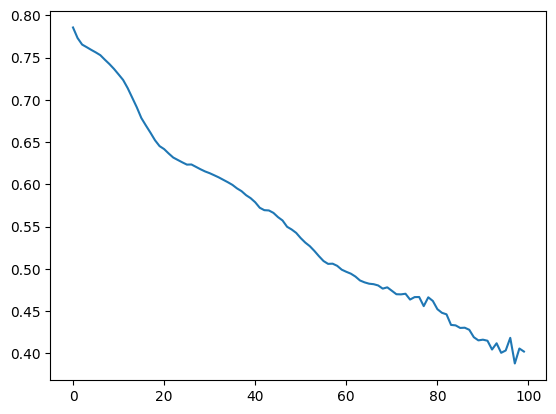

In [24]:
import matplotlib.pyplot as plt

plt.plot(data['192_vineyard']['Deep ReLU ANN']['4']['train_history'])

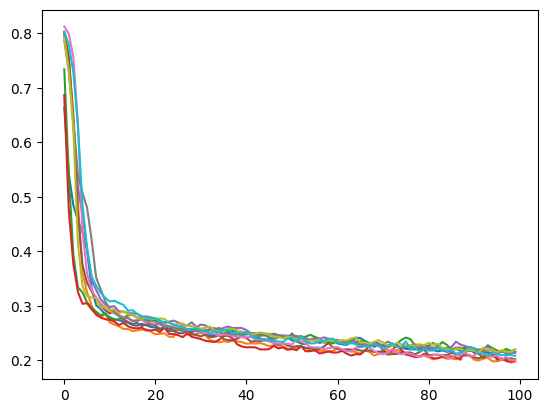

In [25]:
for fold in range(1,11):
    plt.plot(data['1027_ESL']['Deep ReLU ANN'][str(fold)]['train_history'])

In [26]:
# Function to calculate mean of a metric for each fold for each model, over all datasets
def calculate_mean_metric(metric):
    # Initialize dictionary to hold means
    means = {}

    # Iterate over datasets
    for dataset_name in data:
        # Iterate over models
        for model_name in data[dataset_name]:
            # Initialize sum and count for this model
            sum_metric = 0.0
            count = 0

            # Iterate over folds
            for fold_number in data[dataset_name][model_name]:
                # Add metric to sum and increment count
                sum_metric += data[dataset_name][model_name][fold_number][metric]
                count += 1

            # Calculate mean and add to dictionary
            mean_metric = sum_metric / count if count > 0 else None
            
            if dataset_name not in means:
                means[dataset_name] = {}
                
            if model_name not in means[dataset_name]:
                means[dataset_name][model_name] = {}

            means[dataset_name][model_name] = mean_metric

    return means

# Calculate mean r_squared value for each fold for each model, over all datasets
mean_r_squared_values = calculate_mean_metric('r_squared_value')
print(mean_r_squared_values)

# Calculate mean test_error value for each fold for each model, over all datasets
mean_test_error_values = calculate_mean_metric('test_error')
print(mean_test_error_values)

# Calculate mean loss value for each fold for each model, over all datasets
mean_loss_values = calculate_mean_metric('loss')
print(mean_loss_values)

{'1027_ESL': {'ABEL-Spline (z=1)': 0.8453176101306769, 'ABEL-Spline (z=10)': 0.8366582258656345, 'ABEL-Spline (z=2)': 0.842621588421802, 'ABEL-Spline (z=4)': 0.8368421813272482, 'ABEL-Spline (z=8)': 0.8361386400027264, 'Deep ReLU ANN': 0.8401340195389551, 'Linear Model': 0.819472454833084, 'Lookup Table (z=1)': -0.07045607803392373, 'Lookup Table (z=10)': 0.3436571120480124, 'Lookup Table (z=2)': 0.6280674854342622, 'Lookup Table (z=4)': 0.5965395451964313, 'Lookup Table (z=8)': 0.4089177818588821, 'One Parameter': -0.07059850495252755, 'Spline ANN (z=1)': 0.841612404587002, 'Spline ANN (z=10)': 0.8361209728750119, 'Spline ANN (z=2)': 0.8440268628065816, 'Spline ANN (z=4)': 0.8397476058295197, 'Spline ANN (z=8)': 0.836411008068189, 'Wide ReLU ANN': 0.8342730456310304}, '1029_LEV': {'ABEL-Spline (z=1)': 0.5373451674617844, 'ABEL-Spline (z=10)': 0.525077832383308, 'ABEL-Spline (z=2)': 0.5278395456476376, 'ABEL-Spline (z=4)': 0.5270126938629811, 'ABEL-Spline (z=8)': 0.5264574526818857, 'D

In [27]:
mean_test_error_values['1027_ESL']

{'ABEL-Spline (z=1)': 0.14384808544517258,
 'ABEL-Spline (z=10)': 0.15440449976251,
 'ABEL-Spline (z=2)': 0.1476589163205736,
 'ABEL-Spline (z=4)': 0.1537955905837096,
 'ABEL-Spline (z=8)': 0.1549113411662661,
 'Deep ReLU ANN': 0.1475142622440601,
 'Linear Model': 0.17549205033822723,
 'Lookup Table (z=1)': 1.0337721047242288,
 'Lookup Table (z=10)': 0.6565459842249888,
 'Lookup Table (z=2)': 0.3714907159858948,
 'Lookup Table (z=4)': 0.4045255229857675,
 'Lookup Table (z=8)': 0.5903244132387122,
 'One Parameter': 1.033869189007921,
 'Spline ANN (z=1)': 0.1500431465424922,
 'Spline ANN (z=10)': 0.15768204258535815,
 'Spline ANN (z=2)': 0.1469465606236542,
 'Spline ANN (z=4)': 0.15300694201205106,
 'Spline ANN (z=8)': 0.15720151276518007,
 'Wide ReLU ANN': 0.15218352262442086}

In [28]:
# Function to calculate mean and standard deviation of a metric for each fold for each model, over all datasets
def calculate_mean_std_metric(metric):
    # Initialize dictionary to hold means and standard deviations
    means_stds = {}

    # Iterate over datasets
    for dataset_name in data:
        # Iterate over models
        for model_name in data[dataset_name]:
            # Initialize list to hold metric values for this model
            metric_values = []

            # Iterate over folds
            for fold_number in data[dataset_name][model_name]:
                # Add metric value to list
                metric_values.append(data[dataset_name][model_name][fold_number][metric])

            # Calculate mean and standard deviation and add to dictionary
            mean_metric = np.mean(metric_values)
            std_metric = np.std(metric_values)
            
            if dataset_name not in means_stds:
                means_stds[dataset_name] = {}
                
            if model_name not in means_stds[dataset_name]:
                means_stds[dataset_name][model_name] = {}

            means_stds[dataset_name][model_name]['mean'] = mean_metric
            means_stds[dataset_name][model_name]['std'] = std_metric

    return means_stds

# Calculate mean and standard deviation of r_squared value for each fold for each model, over all datasets
mean_std_r_squared_values = calculate_mean_std_metric('r_squared_value')
print(mean_std_r_squared_values)

# Calculate mean and standard deviation of test_error value for each fold for each model, over all datasets
mean_std_test_error_values = calculate_mean_std_metric('test_error')
print(mean_std_test_error_values)

# Calculate mean and standard deviation of loss value for each fold for each model, over all datasets
mean_std_loss_values = calculate_mean_std_metric('loss')
print(mean_std_loss_values)

{'1027_ESL': {'ABEL-Spline (z=1)': {'mean': 0.8453176101306769, 'std': 0.03865829907616997}, 'ABEL-Spline (z=10)': {'mean': 0.8366582258656348, 'std': 0.033362219564155526}, 'ABEL-Spline (z=2)': {'mean': 0.842621588421802, 'std': 0.03581119376100707}, 'ABEL-Spline (z=4)': {'mean': 0.8368421813272482, 'std': 0.03534704597109858}, 'ABEL-Spline (z=8)': {'mean': 0.8361386400027264, 'std': 0.033554897249041746}, 'Deep ReLU ANN': {'mean': 0.8401340195389553, 'std': 0.049370697671445155}, 'Linear Model': {'mean': 0.819472454833084, 'std': 0.03107981148141429}, 'Lookup Table (z=1)': {'mean': -0.07045607803392373, 'std': 0.10994675766466704}, 'Lookup Table (z=10)': {'mean': 0.3436571120480124, 'std': 0.061567539744681585}, 'Lookup Table (z=2)': {'mean': 0.6280674854342622, 'std': 0.058819963032131016}, 'Lookup Table (z=4)': {'mean': 0.5965395451964313, 'std': 0.05704621757655317}, 'Lookup Table (z=8)': {'mean': 0.4089177818588821, 'std': 0.05106908770146579}, 'One Parameter': {'mean': -0.070598

In [29]:
mean_std_test_error_values['1027_ESL']['ABEL-Spline (z=4)']

{'mean': 0.1537955905837096, 'std': 0.03651069763983501}

In [30]:
# Function to save means and standard deviations to a text file in LaTeX table format
def save_to_file(means_stds, filename):
    # Open file
    with open(filename, 'w') as f:
        # Write table header
        f.write("\\begin{tabular}{|c|c|c|c|}\n")
        f.write("\\hline\n")
        f.write("Dataset & Model & Mean & Standard Deviation \\\\\n")
        f.write("\\hline\n")

        # Iterate over datasets
        for dataset_name in means_stds:
            # Iterate over models
            for model_name in means_stds[dataset_name]:
                # Write row data
                mean = means_stds[dataset_name][model_name]['mean']
                std = means_stds[dataset_name][model_name]['std']
                f.write(f"{dataset_name} & {model_name} & {mean:.3f} $\pm$ {std:.3f} \\\\\n")

        # Write table footer
        f.write("\\hline\n")
        f.write("\\end{tabular}\n")

# Save mean and standard deviation of r_squared value to file
save_to_file(mean_std_r_squared_values, 'r_squared_values.txt')

# Save mean and standard deviation of test_error value to file
save_to_file(mean_std_test_error_values, 'test_error_values.txt')

# Save mean and standard deviation of loss value to file
save_to_file(mean_std_loss_values, 'loss_values.txt')

In [31]:
# Function to save means and standard deviations to a text file in LaTeX table format
def save_to_file(means_stds, filename):
    # Open file
    with open(filename, 'w') as f:
        # Write table header
        f.write("\\begin{tabular}{|c|c|c|c|}\n")
        f.write("\\hline\n")
        f.write("Model & Dataset & Mean & Standard Deviation \\\\\n")
        f.write("\\hline\n")

        # Iterate over models
        for model_name in means_stds:
            # Iterate over datasets
            for dataset_name in means_stds[model_name]:
                # Write row data
                mean = means_stds[model_name][dataset_name]['mean']
                std = means_stds[model_name][dataset_name]['std']
                f.write(f"{model_name} & {dataset_name.replace('_', r'\_')} & {mean:.3f} $\\pm$ {std:.3f} \\\\\n")

        # Write table footer
        f.write("\\hline\n")
        f.write("\\end{tabular}\n")

# Save mean and standard deviation of r_squared value to file
save_to_file(mean_std_r_squared_values, 'r_squared_values.txt')

# Save mean and standard deviation of test_error value to file
save_to_file(mean_std_test_error_values, 'test_error_values.txt')

# Save mean and standard deviation of loss value to file
save_to_file(mean_std_loss_values, 'loss_values.txt')

SyntaxError: f-string expression part cannot include a backslash (3124979905.py, line 18)

In [32]:
# Function to save means and standard deviations to a text file in LaTeX table format
def save_to_file(means_stds, filename):
    # Open file
    with open(filename, 'w') as f:
        # Write table header
        f.write("\\begin{tabular}{|l|c|c|}\n")
        f.write("\\hline\n")
        f.write("Model & Dataset & Mean $\pm$ Standard Deviation \\\\\n")
        f.write("\\hline\n")

        # Iterate over models
        for model_name in model_names:
            for dataset_name in means_stds:
                if model_name in means_stds[dataset_name]:
                    # Write row data
                    mean = means_stds[dataset_name][model_name]['mean']
                    std = means_stds[dataset_name][model_name]['std']
                    dataset_name_tex = "\\texttt{" + dataset_name.replace("_", "\\_") + "}"
                    f.write(f"{model_name} & {dataset_name_tex} & {mean:.3f} $\\pm$ {std:.3f} \\\\\n")

        # Write table footer
        f.write("\\hline\n")
        f.write("\\end{tabular}\n")

# Save mean and standard deviation of r_squared value to file
save_to_file(mean_std_r_squared_values, 'r_squared_values.txt')

# Save mean and standard deviation of test_error value to file
save_to_file(mean_std_test_error_values, 'test_error_values.txt')

# Save mean and standard deviation of loss value to file
save_to_file(mean_std_loss_values, 'loss_values.txt')

In [33]:
# Function to save means and standard deviations to a text file in LaTeX table format
def save_to_file(means_stds, filename):
    # Open file
    with open(filename, 'w') as f:
        # Write table header
        all_datasets = list(means_stds.keys())
        header = " & ".join(["\\texttt{" + dataset.replace("_", "\\_") + "}" for dataset in all_datasets])
        f.write("\\begin{tabular}{|l|" + "c|"*len(all_datasets) + "}\n")
        f.write("\\hline\n")
        f.write("Model & " + header + " \\\\\n")
        f.write("\\hline\n")

        # Iterate over models
        for model_name in model_names:
            row_data = []
            for dataset_name in all_datasets:
                if model_name in means_stds[dataset_name]:
                    # Write row data
                    mean = means_stds[dataset_name][model_name]['mean']
                    std = means_stds[dataset_name][model_name]['std']
                    row_data.append(f"{mean:.3f} $\\pm$ {std:.3f}")
                else:
                    row_data.append("-")
            f.write(f"{model_name} & " + " & ".join(row_data) + " \\\\\n")

        # Write table footer
        f.write("\\hline\n")
        f.write("\\end{tabular}\n")

# Save mean and standard deviation of r_squared value to file
save_to_file(mean_std_r_squared_values, 'r_squared_values.txt')

# Save mean and standard deviation of test_error value to file
save_to_file(mean_std_test_error_values, 'test_error_values.txt')

# Save mean and standard deviation of loss value to file
save_to_file(mean_std_loss_values, 'loss_values.txt')

In [34]:
filtered_datasets_metadata, datasets = fetch_return_filtered_pmlb_data_sets()
filtered_datasets_metadata

,dataset,n_instances,n_features,n_binary_features,n_categorical_features,n_continuous_features,endpoint_type,n_classes,imbalance,task
0,1027_ESL,488,4,0,0,4,continuous,9.0,0.099363,regression
2,1029_LEV,1000,4,0,0,4,continuous,5.0,0.111245,regression
3,1030_ERA,1000,4,0,0,4,continuous,9.0,0.031251,regression
5,1096_FacultySalaries,50,4,0,0,4,continuous,39.0,0.004063,regression
13,192_vineyard,52,2,0,0,2,continuous,19.0,0.040475,regression
23,228_elusage,55,2,0,0,2,continuous,52.0,0.000953,regression
25,230_machine_cpu,209,6,0,0,6,continuous,116.0,0.004906,regression
29,485_analcatdata_vehicle,48,4,0,0,4,continuous,47.0,0.000434,regression
32,519_vinnie,380,2,0,0,2,continuous,16.0,0.030146,regression
34,523_analcatdata_neavote,100,2,0,0,2,continuous,8.0,0.136914,regression


In [35]:
filtered_datasets_metadata.columns

Index(['dataset', 'n_instances', 'n_features', 'n_binary_features',
       'n_categorical_features', 'n_continuous_features', 'endpoint_type',
       'n_classes', 'imbalance', 'task'],
      dtype='object')

In [36]:
# Function to save means and standard deviations to a text file in LaTeX table format
def save_to_file(means_stds, filename):
    # Create a dictionary mapping dataset names to number of instances
    instances_dict = filtered_datasets_metadata.set_index('dataset')['n_instances'].to_dict()

    # Get all datasets and sort them based on number of instances
    all_datasets = sorted(list(means_stds.keys()), key=lambda x: instances_dict[x])
    print(all_datasets)

    # Open file
    with open(filename, 'w') as f:
        # Write table header
        header = " & ".join(["\\texttt{" + dataset.replace("_", "\\_") + "}" for dataset in all_datasets])
        f.write("\\begin{tabular}{|l|" + "c|"*len(all_datasets) + "}\n")
        f.write("\\hline\n")
        f.write("Model & " + header + " \\\\\n")
        f.write("\\hline\n")

        # Iterate over models
        for model_name in model_names:
            row_data = []
            for dataset_name in all_datasets:
                if model_name in means_stds[dataset_name]:
                    # Write row data
                    mean = means_stds[dataset_name][model_name]['mean']
                    std = means_stds[dataset_name][model_name]['std']
                    row_data.append(f"{mean:.3f} $\\pm$ {std:.3f}")
                else:
                    row_data.append("-")
            f.write(f"{model_name} & " + " & ".join(row_data) + " \\\\\n")

        # Write table footer
        f.write("\\hline\n")
        f.write("\\end{tabular}\n")

# Save mean and standard deviation of r_squared value to file
save_to_file(mean_std_r_squared_values, 'r_squared_values.txt')

# Save mean and standard deviation of test_error value to file
save_to_file(mean_std_test_error_values, 'test_error_values.txt')

# Save mean and standard deviation of loss value to file
save_to_file(mean_std_loss_values, 'loss_values.txt')

['485_analcatdata_vehicle', '1096_FacultySalaries', '192_vineyard', '228_elusage', '687_sleuth_ex1605', '706_sleuth_case1202', '523_analcatdata_neavote', '594_fri_c2_100_5', '611_fri_c3_100_5', '624_fri_c0_100_5', '656_fri_c1_100_5', '678_visualizing_environmental', '663_rabe_266', '665_sleuth_case2002', '230_machine_cpu', '712_chscase_geyser1', '579_fri_c0_250_5', '596_fri_c2_250_5', '601_fri_c1_250_5', '613_fri_c3_250_5', '690_visualizing_galaxy', '519_vinnie', '556_analcatdata_apnea2', '557_analcatdata_apnea1', '1027_ESL', '597_fri_c2_500_5', '617_fri_c3_500_5', '631_fri_c1_500_5', '649_fri_c0_500_5', '1029_LEV', '1030_ERA', '599_fri_c2_1000_5', '609_fri_c0_1000_5', '612_fri_c1_1000_5', '628_fri_c3_1000_5', 'titanic', '529_pollen', 'banana']
['485_analcatdata_vehicle', '1096_FacultySalaries', '192_vineyard', '228_elusage', '687_sleuth_ex1605', '706_sleuth_case1202', '523_analcatdata_neavote', '594_fri_c2_100_5', '611_fri_c3_100_5', '624_fri_c0_100_5', '656_fri_c1_100_5', '678_visual

In [37]:
# Function to save means and standard deviations to a text file in LaTeX table format
# models on top and datasets in each row
def save_to_file(means_stds, filename):
    # Create a dictionary mapping dataset names to number of instances
    instances_dict = filtered_datasets_metadata.set_index('dataset')['n_instances'].to_dict()

    # Get all datasets and sort them based on number of instances
    all_datasets = sorted(list(means_stds.keys()), key=lambda x: instances_dict[x])

    # Open file
    with open(filename, 'w') as f:
        # Write table header
        header = " & ".join(model_names)
        f.write("\\begin{tabular}{|l|" + "c|"*len(model_names) + "}\n")
        f.write("\\hline\n")
        f.write("Dataset & " + header + " \\\\\n")
        f.write("\\hline\n")

        # Iterate over datasets
        for dataset_name in all_datasets:
            row_data = []
            for model_name in model_names:
                if model_name in means_stds[dataset_name]:
                    # Write row data
                    mean = means_stds[dataset_name][model_name]['mean']
                    std = means_stds[dataset_name][model_name]['std']
                    row_data.append(f"{mean:.3f} $\\pm$ {std:.3f}")
                else:
                    row_data.append("-")
            dataset_name_tex = "\\texttt{" + dataset_name.replace("_", "\\_") + "}"
            f.write(f"{dataset_name_tex} & " + " & ".join(row_data) + " \\\\\n")

        # Write table footer
        f.write("\\hline\n")
        f.write("\\end{tabular}\n")

# Save mean and standard deviation of r_squared value to file
save_to_file(mean_std_r_squared_values, 'r_squared_values.txt')

# Save mean and standard deviation of test_error value to file
save_to_file(mean_std_test_error_values, 'test_error_values.txt')

# Save mean and standard deviation of loss value to file
save_to_file(mean_std_loss_values, 'loss_values.txt')

In [38]:
# Function to save means and standard deviations to a text file in LaTeX table format
def save_to_file(means_stds, filename):
    # Create a dictionary mapping dataset names to number of instances
    instances_dict = filtered_datasets_metadata.set_index('dataset')['n_instances'].to_dict()

    # Get all datasets and sort them based on number of instances
    all_datasets = sorted(list(means_stds.keys()), key=lambda x: instances_dict[x])

    # Open file
    with open(filename, 'w') as f:
        # Write table header
        header = " & ".join(["\\texttt{" + dataset.replace("_", "\\_") + "}" for dataset in all_datasets])
        f.write("\\begin{tabular}{|l|" + "c|"*len(all_datasets) + "}\n")
        f.write("\\hline\n")
        f.write("Model & " + header + " \\\\\n")
        f.write("\\hline\n")

        # Iterate over models
        for model_name in model_names:
            row_data = []
            for dataset_name in all_datasets:
                if model_name in means_stds[dataset_name]:
                    # Write row data
                    mean = means_stds[dataset_name][model_name]['mean']
                    std = means_stds[dataset_name][model_name]['std']
                    row_data.append(f"{mean:.3f} $\\pm$ {std:.3f}")
                else:
                    row_data.append("-")
            f.write(f"{model_name} & " + " & ".join(row_data) + " \\\\\n")

        # Write table footer
        f.write("\\hline\n")
        f.write("\\end{tabular}\n")

# Save mean and standard deviation of r_squared value to file
save_to_file(mean_std_r_squared_values, 'r_squared_values.txt')

# Save mean and standard deviation of test_error value to file
save_to_file(mean_std_test_error_values, 'test_error_values.txt')

# Save mean and standard deviation of loss value to file
save_to_file(mean_std_loss_values, 'loss_values.txt')

In [43]:
# attempt to partition and sort
# Function to save means and standard deviations to a text file in LaTeX table format
def save_to_file(means_stds, filename):
    # Create dictionaries mapping dataset names to number of instances and number of features
    instances_dict = filtered_datasets_metadata.set_index('dataset')['n_instances'].to_dict()
    features_dict = filtered_datasets_metadata.set_index('dataset')['n_features'].to_dict()

    # Get all unique feature counts
    unique_features_counts = sorted(list(set(features_dict.values())))

    # Open file
    with open(filename, 'w') as f:

        # Iterate over feature counts
        for feature_count in unique_features_counts:
            # Get datasets with current feature count and sort them based on number of instances
            datasets_with_feature_count = [dataset for dataset, features in features_dict.items() if features == feature_count]
            sorted_datasets = sorted(datasets_with_feature_count, key=lambda x: instances_dict[x])

            if not sorted_datasets:
                continue

            # Write table header
            header = " & ".join(["\\texttt{" + dataset.replace("_", "\\_") + "}" for dataset in sorted_datasets])
            f.write("\\begin{tabular}{|l|" + "c|"*len(sorted_datasets) + "}\n")
            f.write("\\hline\n")
            f.write("Model & " + header + " \\\\\n")
            f.write("\\hline\n")

            # Iterate over models
            for model_name in model_names:
                row_data = []
                for dataset_name in sorted_datasets:
                    if model_name in means_stds[dataset_name]:
                        # Write row data
                        mean = means_stds[dataset_name][model_name]['mean']
                        std = means_stds[dataset_name][model_name]['std']
                        row_data.append(f"{mean:.3f} $\\pm$ {std:.3f}")
                    else:
                        row_data.append("-")
                f.write(f"{model_name} & " + " & ".join(row_data) + " \\\\\n")

            # Write table footer
            f.write("\\hline\n")
            f.write("\\end{tabular}\n")
            f.write("\n")

# Save mean and standard deviation of r_squared value to file
save_to_file(mean_std_r_squared_values, 'r_squared_values.txt')

# Save mean and standard deviation of test_error value to file
save_to_file(mean_std_test_error_values, 'test_error_values.txt')

# Save mean and standard deviation of loss value to file
save_to_file(mean_std_loss_values, 'loss_values.txt')

In [44]:
# try rotating headers

# Function to save means and standard deviations to a text file in LaTeX table format
def save_to_file(means_stds, filename):
    # Create dictionaries mapping dataset names to number of instances and number of features
    instances_dict = filtered_datasets_metadata.set_index('dataset')['n_instances'].to_dict()
    features_dict = filtered_datasets_metadata.set_index('dataset')['n_features'].to_dict()

    # Get all unique feature counts
    unique_features_counts = sorted(list(set(features_dict.values())))

    # Open file
    with open(filename, 'w') as f:

        # Iterate over feature counts
        for feature_count in unique_features_counts:
            # Get datasets with current feature count and sort them based on number of instances
            datasets_with_feature_count = [dataset for dataset, features in features_dict.items() if features == feature_count]
            sorted_datasets = sorted(datasets_with_feature_count, key=lambda x: instances_dict[x])

            if not sorted_datasets:
                continue

            # Write table header with \rotatebox{90} for each dataset name
            header = " & ".join(["\\rotatebox{90}{\\texttt{" + dataset.replace("_", "\\_") + "}}" for dataset in sorted_datasets])
            f.write("\\begin{tabular}{|l|" + "c|"*len(sorted_datasets) + "}\n")
            f.write("\\hline\n")
            f.write("Model & " + header + " \\\\\n")
            f.write("\\hline\n")

            # Iterate over models
            for model_name in model_names:
                row_data = []
                for dataset_name in sorted_datasets:
                    if model_name in means_stds[dataset_name]:
                        # Write row data
                        mean = means_stds[dataset_name][model_name]['mean']
                        std = means_stds[dataset_name][model_name]['std']
                        row_data.append(f"{mean:.3f} $\\pm$ {std:.3f}")
                    else:
                        row_data.append("-")
                f.write(f"{model_name} & " + " & ".join(row_data) + " \\\\\n")

            # Write table footer
            f.write("\\hline\n")
            f.write("\\end{tabular}\n")
            f.write("\n")

In [45]:
# Function to save means and standard deviations to a text file in LaTeX table format
def save_to_file(means_stds, filename):
    # Create dictionaries mapping dataset names to number of instances and number of features
    instances_dict = filtered_datasets_metadata.set_index('dataset')['n_instances'].to_dict()
    features_dict = filtered_datasets_metadata.set_index('dataset')['n_features'].to_dict()

    # Get all unique feature counts
    unique_features_counts = sorted(list(set(features_dict.values())))

    # Open file
    with open(filename, 'w') as f:

        # Iterate over feature counts
        for feature_count in unique_features_counts:
            # Get datasets with current feature count and sort them based on number of instances
            datasets_with_feature_count = [dataset for dataset, features in features_dict.items() if features == feature_count]
            sorted_datasets = sorted(datasets_with_feature_count, key=lambda x: instances_dict[x])

            if not sorted_datasets:
                continue

            # Write table header with \rotatebox{90} for each dataset name
            header = " & ".join(["\\rotatebox{90}{\\texttt{" + dataset.replace("_", "\\_") + "}}" for dataset in sorted_datasets])
            f.write("\\begin{tabular}{|l|" + "c|"*len(sorted_datasets) + "}\n")
            f.write("\\hline\n")
            f.write("Model & " + header + " \\\\\n")
            f.write("\\hline\n")

            # Iterate over models
            for model_name in model_names:
                row_data = []
                for dataset_name in sorted_datasets:
                    if model_name in means_stds[dataset_name]:
                        # Write row data
                        mean = means_stds[dataset_name][model_name]['mean']
                        std = means_stds[dataset_name][model_name]['std']
                        row_data.append(f"{mean:.3f} $\\pm$ {std:.3f}")
                    else:
                        row_data.append("-")
                f.write(f"{model_name} & " + " & ".join(row_data) + " \\\\\n")

            # Write table footer
            f.write("\\hline\n")
            f.write("\\end{tabular}\n")
            f.write("\n")

In [42]:
# Calculate mean and standard deviation of r_squared value for each fold for each model, over all datasets
mean_std_r_squared_values = calculate_mean_std_metric('r_squared_value')

# Create a dictionary mapping dataset names to number of instances and features
instances_dict = filtered_datasets_metadata.set_index('dataset')['n_instances'].to_dict()
features_dict = filtered_datasets_metadata.set_index('dataset')['n_features'].to_dict()

# Get all datasets and partition them based on number of features (less than 7)
partitions = [[] for _ in range(2,)]
for dataset_name in mean_std_r_squared_values.keys():
    n_features = features_dict[dataset_name]
    if n_features < 7:
        partitions[n_features].append(dataset_name)

# Sort each partition based on number of instances
sorted_partitions = [sorted(partition, key=lambda x: instances_dict[x]) for partition in partitions]

# Now you can save each partition to a separate file using save_to_file() function:
for i, partition in enumerate(sorted_partitions):
    # Create a new dictionary containing only datasets from this partition
    means_stds_partition = {dataset: mean_std_r_squared_values[dataset] for dataset in partition}

    # Save mean and standard deviation of r_squared value to file
    save_to_file(means_stds_partition, f'r_squared_values_{i}.txt')

IndexError: list index out of range

In [41]:
# attempt to place in one file

# Function to save means and standard deviations to a text file in LaTeX table format
def save_to_file(means_stds_partitions, filename):
    # Open file
    with open(filename, 'w') as f:
        for i, means_stds in enumerate(means_stds_partitions):
            # Write partition header
            f.write(f"Partition {i+1}\n\n")

            # Get all datasets and sort them based on number of instances
            all_datasets = sorted(list(means_stds.keys()), key=lambda x: instances_dict[x])

            # Write table header
            header = " & ".join(["\\texttt{" + dataset.replace("_", "\\_") + "}" for dataset in all_datasets])
            f.write("\\begin{tabular}{|l|" + "c|"*len(all_datasets) + "}\n")
            f.write("\\hline\n")
            f.write("Model & " + header + " \\\\\n")
            f.write("\\hline\n")

            # Iterate over models
            for model_name in model_names:
                row_data = []
                for dataset_name in all_datasets:
                    if model_name in means_stds[dataset_name]:
                        # Write row data
                        mean = means_stds[dataset_name][model_name]['mean']
                        std = means_stds[dataset_name][model_name]['std']
                        row_data.append(f"{mean:.3f} $\\pm$ {std:.3f}")
                    else:
                        row_data.append("-")
                f.write(f"{model_name} & " + " & ".join(row_data) + " \\\\\n")

            # Write table footer
            f.write("\\hline\n")
            f.write("\\end{tabular}\n")

            # Write two new lines between tables
            f.write("\n\n")

# Create a list of dictionaries containing only datasets from each partition
means_stds_partitions = []
for partition in sorted_partitions:
    means_stds_partition = {dataset: mean_std_r_squared_values[dataset] for dataset in partition}
    means_stds_partitions.append(means_stds_partition)

# Save mean and standard deviation of r_squared value to file
save_to_file(means_stds_partitions, 'r_squared_values.txt')

In [37]:
# Function to save means and standard deviations to a text file in LaTeX table format (reversed)
def save_to_file_reversed(means_stds, filename):
    # Create a dictionary mapping dataset names to number of instances
    instances_dict = filtered_datasets_metadata.set_index('dataset')['n_instances'].to_dict()

    # Get all datasets and sort them based on number of instances
    all_datasets = sorted(list(means_stds.keys()), key=lambda x: instances_dict[x])

    # Open file
    with open(filename, 'w') as f:
        # Write table header
        header = " & ".join(model_names)
        f.write("\\begin{tabular}{|l|" + "c|"*len(model_names) + "}\n")
        f.write("\\hline\n")
        f.write("\\texttt{Dataset} & " + header + " \\\\\n")
        f.write("\\hline\n")

        # Iterate over datasets
        for dataset_name in all_datasets:
            row_data = []
            for model_name in model_names:
                if model_name in means_stds[dataset_name]:
                    # Write row data
                    mean = means_stds[dataset_name][model_name]['mean']
                    std = means_stds[dataset_name][model_name]['std']
                    row_data.append(f"{mean:.3f} $\\pm$ {std:.3f}")
                else:
                    row_data.append("-")
            f.write(f"\\texttt{{{dataset_name.replace('_', '\\_')}}} & " + " & ".join(row_data) + " \\\\\n")

        # Write table footer
        f.write("\\hline\n")
        f.write("\\end{tabular}\n")

# Save mean and standard deviation of r_squared value to file
save_to_file_reversed(mean_std_r_squared_values, 'r_squared_values.txt')

# Save mean and standard deviation of test_error value to file
save_to_file_reversed(mean_std_test_error_values, 'test_error_values.txt')

# Save mean and standard deviation of loss value to file
save_to_file_reversed(mean_std_loss_values, 'loss_values.txt')

SyntaxError: f-string expression part cannot include a backslash (4210767875.py, line 29)

In [34]:
import matplotlib.pyplot as plt

# Initialize list to hold model names and dataset names
model_names = []
dataset_names = []

# Iterate over files in directory
for filename in os.listdir(directory):
    if "-epochs-100-fold-" in filename and "-of-10.npy" in filename:
        
        # Split filename into parts
        parts = filename.split('-')
        
        # Extract dataset name (up to first hyphen)
        dataset_name = parts[0]
        
        # Extract model name (from first hyphen to "epochs")
        model_name_parts = parts[1:-6].copy()
        model_name = '-'.join(model_name_parts)

        # Skip file if not one of the expected models
        if model_name not in model_names:
            continue
            
        # Extract fold number (from "fold" to "of")
        fold_number = parts[-3]
        
        # Load file 
        file_data = np.load(os.path.join(directory, filename), allow_pickle=True).item()

        # Add data to dictionary
        if dataset_name not in data:
            data[dataset_name] = {}
            dataset_names.append(dataset_name)  # Add to dataset names list
            
        if model_name not in data[dataset_name]:
            data[dataset_name][model_name] = {}
            if model_name not in model_names:  # Add to model names list only once
                model_names.append(model_name)

        data[dataset_name][model_name][fold_number] = file_data

# Now you can access the data as follows:
# data[dataset_name][model_name][fold_number]


In [35]:
data[dataset_names]

In [37]:
dataset_name

'titanic'